In [1]:
import numpy as np
import pandas as pd
from tensorflow.python import keras
from tensorflow.python.keras import models, layers
from keras.optimizers import RMSprop, Adam
#from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.models import Sequential
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load the data file.

data_dir = '/kaggle/input/jena-climate-2009-2016'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

data_orig = pd.read_csv(fname)
data_orig.head()
data_orig.describe()


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [3]:
# Consider only the temperature data.

T = np.asarray(data_orig['T (degC)'])

# Normalize the data to mean 0 and std of 1.
# Use only the first 200,000 timesteps for training.

mean = T[:200000].mean()
T -= mean
std = T[:200000].std()
T /= std

In [4]:
# Data generator for generating data batches on the fly. These will be fed into the RNN.
# Generator yields a tuple of (samples, targets), where samples is one batch of input data
# and targets are the corresponding target temperatures.

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step, 1))
        targets = np.zeros((len(rows), delay))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j,:,0] = data[indices]
            targets[j] = data[rows[j]:rows[j] + delay]
        yield samples, targets

In [5]:
# Preparing train, validation, and test generators.
# Use the first 200,000 timesteps for training, next 100,000 timesteps for
# validation, and rest for testing.

lookback = 720 #1440    # how many timesteps to look back in past
step = 3 #6             # sampling frequency
delay = 144             # how many timesteps into the future target (prediction) should be
batch_size = 128        # number of samples to generate per batch

train_gen = generator(T,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(T,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(T,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(T) - 300001 - lookback) // batch_size

In [6]:
# Instantiate the RNN model for forecasting.

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, 1)))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))

# model.add(layers.GRU(32,
#                      dropout=0.1,
#                      recurrent_dropout=0.5,
#                      return_sequences=True,
#                      input_shape=(None, 1)))
# model.add(layers.GRU(64, activation='relu',
#                      dropout=0.1,
#                      recurrent_dropout=0.5))

model.add(layers.Dense(delay))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 144)               4752      
Total params: 16,432
Trainable params: 16,432
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Configure model for training

model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

In [8]:
# Fit the model using batch generator

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 61s 122ms/step - loss: 0.2239 - mae: 0.3594 - val_loss: 0.1063 - val_mae: 0.2519
Epoch 2/20
500/500 [==============================] - 61s 122ms/step - loss: 0.1241 - mae: 0.2734 - val_loss: 0.1022 - val_mae: 0.2475
Epoch 3/20
500/500 [==============================] - 61s 121ms/step - loss: 0.1146 - mae: 0.2624 - val_loss: 0.0939 - val_mae: 0.2343
Epoch 4/20
500/500 [==============================] - 61s 123ms/step - loss: 0.1102 - mae: 0.2565 - val_loss: 0.0964 - val_mae: 0.2391
Epoch 5/20
500/500 [==============================] - 62s 123ms/step - loss: 0.1074 - mae: 0.2528 - val_loss: 0.0905 - val_mae: 0.2296
Epoch 6/20
500/500 [==============================] - 62s 123ms/step - loss: 0.1057 - mae: 0.2509 - val_loss: 0.0921 - val_mae: 0.2322
Epoch 7/20
500/500 [==============================] - 61s 121ms/step - loss: 0.1027 - mae: 0.2465 - val_loss: 0.0886 - val_mae: 0.2267
Epoch 8/20
500/500 [==============================] - 6

In [9]:
# Save the model, if needed.
model.save('RNN_Conv1D')

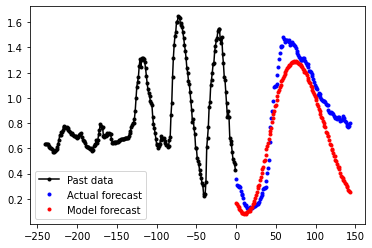

In [10]:
# Finally, evaluate model on the test data. Plot model temperature forecast versus
# the actual temperature data.

test_samples, test_targets = next(test_gen)     # this generates a batch of 128 samples.
preds = model.predict(test_samples)
plt.plot(range(-lookback//step,0), test_samples[0], 'k.-', label='Past data')
plt.plot(range(0,delay), test_targets[0], 'b.', label='Actual forecast')
plt.plot(range(0,delay), preds[0], 'r.', label='Model forecast')
plt.legend()

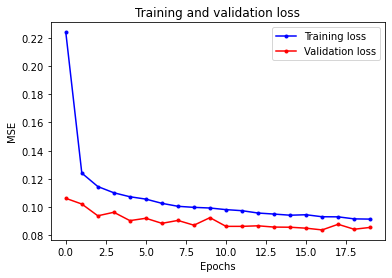

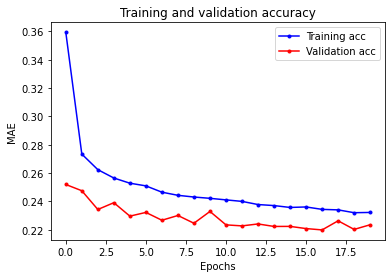

In [15]:
# Plot loss and accuracy (MSE and MAE, respectively).

epochs = 20

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['mae']
val_acc = history.history['val_mae']

plt.plot(range(0,epochs), loss, 'b.-', label='Training loss')
plt.plot(range(0,epochs), val_loss, 'r.-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.figure(2)
plt.plot(range(0,epochs), acc, 'b.-', label='Training acc')
plt.plot(range(0,epochs), val_acc, 'r.-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()